In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch

from segmentation_data import SegmentationData,label_img_to_rgb
from util import download_dataset,visualizer
from nn import SegmentationNN

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline 
plt.rcParams['figure.figsize']=(10.0,8.0)
plt.rcParams['image.interpolation']='nearest'
plt.rcParams['image.cmap']='gray'


%load_ext autoreload
%autoreload 2


In [2]:
os.getcwd(), os.path.dirname(os.path.abspath(os.getcwd()))

('/home/mywsl/Redo/Semantic_Segmentation', '/home/mywsl/Redo')

In [3]:
download_url ='https://i2dl.vc.in.tum.de/static/data/segmentation_data.zip'


i2dl_exercises_path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root = os.path.join(i2dl_exercises_path, 'datasets','segmentation')


download_dataset(
    url=download_url,
    data_dir=data_root,
    dataset_zip_name='segmentation_data.zip',
    force_download=False,
)

train_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/train.txt')
val_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/val.txt')
test_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/test.txt')

75841536it [01:38, 767735.50it/s]                               


In [4]:
from PIL import Image
from torchvision import transforms 

img_id=train_data.image_names[5].replace('.bmp', '')
target = Image.open(os.path.join('/home/mywsl/datasets/segmentation/segmentation_data',
                                         'targets',
                                         img_id + '_GT.bmp'))
center_crop = transforms.CenterCrop(240)
target = center_crop(target)
target = np.array(target, dtype=np.int64)

SEG_LABELS_LIST = [
    {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
    {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
    {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
    {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
    {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
    {"id": 4,  "name": "horse",      "rgb_values": [128, 0,    128]},
    {"id": 5,  "name": "sheep",      "rgb_values": [0,   128,  128]},
    {"id": 6,  "name": "sky",        "rgb_values": [128, 128,  128]},
    {"id": 7,  "name": "mountain",   "rgb_values": [64,  0,    0]},
    {"id": 8,  "name": "airplane",   "rgb_values": [192, 0,    0]},
    {"id": 9,  "name": "water",      "rgb_values": [64,  128,  0]},
    {"id": 10, "name": "face",       "rgb_values": [192, 128,  0]},
    {"id": 11, "name": "car",        "rgb_values": [64,  0,    128]},
    {"id": 12, "name": "bicycle",    "rgb_values": [192, 0,    128]},
    {"id": 13, "name": "flower",     "rgb_values": [64,  128,  128]},
    {"id": 14, "name": "sign",       "rgb_values": [192, 128,  128]},
    {"id": 15, "name": "bird",       "rgb_values": [0,   64,   0]},
    {"id": 16, "name": "book",       "rgb_values": [128, 64,   0]},
    {"id": 17, "name": "chair",      "rgb_values": [0,   192,  0]},
    {"id": 18, "name": "road",       "rgb_values": [128, 64,   128]},
    {"id": 19, "name": "cat",        "rgb_values": [0,   192,  128]},
    {"id": 20, "name": "dog",        "rgb_values": [128, 192,  128]},
    {"id": 21, "name": "body",       "rgb_values": [64,  64,   0]},
    {"id": 22, "name": "boat",       "rgb_values": [192, 64,   0]}]

target=train_data[4][1].numpy()
label_img = np.squeeze(target)
labels = np.unique(target)
label_infos = [l for l in SEG_LABELS_LIST if l['id'] in labels]
label_infos

[{'id': -1, 'name': 'void', 'rgb_values': [0, 0, 0]},
 {'id': 14, 'name': 'sign', 'rgb_values': [192, 128, 128]}]

Train size: 276
Validation size: 59
Img size:  torch.Size([3, 240, 240])
Segmentation size:  torch.Size([240, 240])


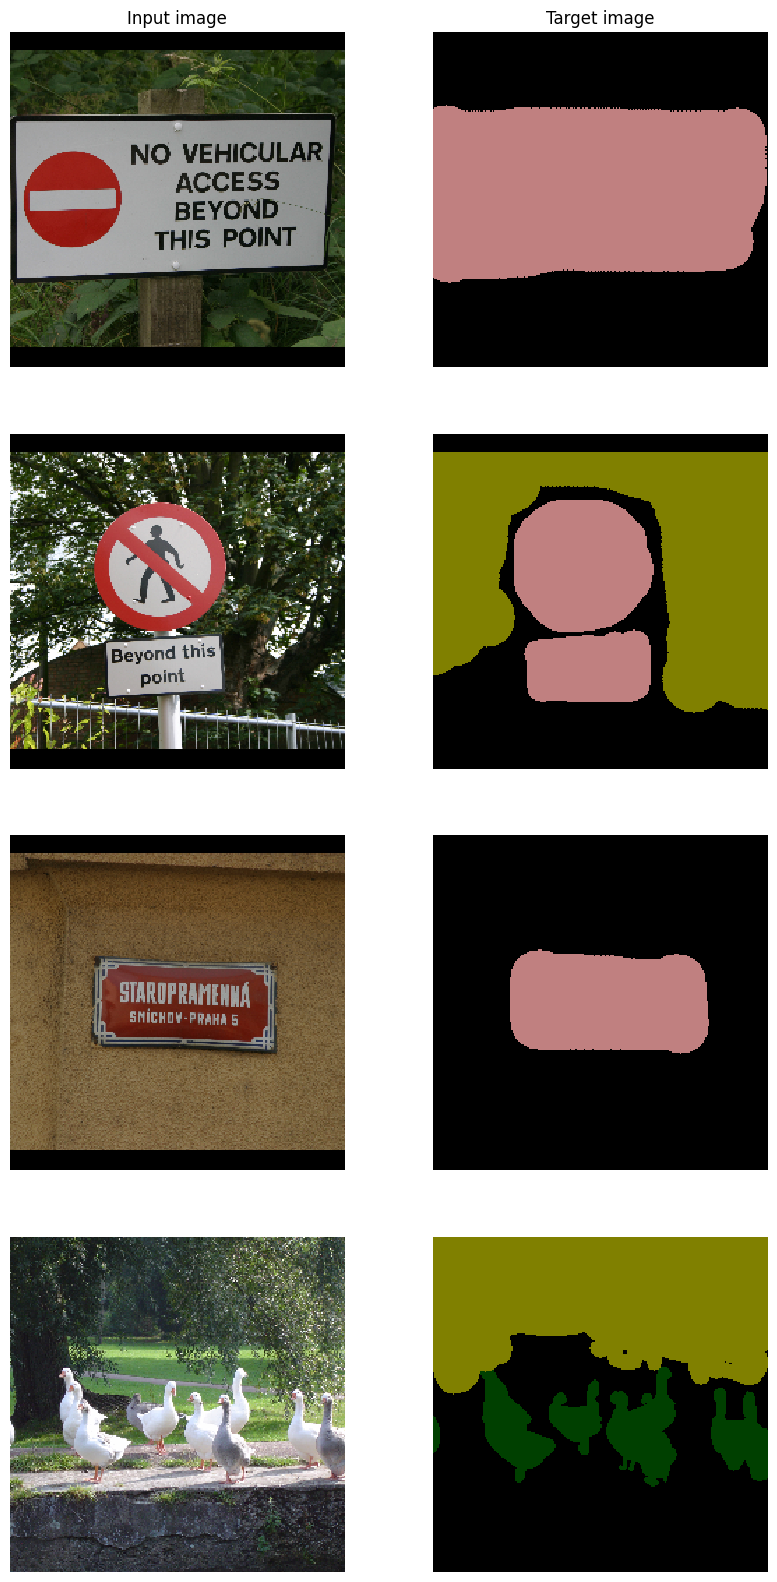

In [5]:
print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Img size: ", train_data[0][0].size())
print("Segmentation size: ", train_data[0][1].size())

num_example_imgs = 4
plt.figure(figsize=(10, 5 * num_example_imgs))
for i, (img, target) in enumerate(train_data[:num_example_imgs]):
    # img
    plt.subplot(num_example_imgs, 2, i * 2 + 1)
    plt.imshow(img.numpy().transpose(1,2,0))
    plt.axis('off')
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 2, i * 2 + 2)
    plt.imshow(label_img_to_rgb(target.numpy()))
    plt.axis('off')
    if i == 0:
        plt.title("Target image")
plt.show()

In [6]:
import torchvision.models as models
pretrained_model=models.alexnet(pretrained=True).features
hparams = {
    "pretrained_model":pretrained_model,
    "learning_rate":1.3e-3,
    "batch_size":20
    
}



/home/mywsl/miniconda3/envs/base2/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mywsl/miniconda3/envs/base2/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:

train_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/train.txt')
val_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/val.txt') #from exercise_8.exercise_code.models import Classifier

train_loader = torch.utils.data.DataLoader(train_data, batch_size=hparams["batch_size"], shuffle=False, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=hparams["batch_size"], shuffle=False, num_workers=0)
    

model = SegmentationNN(hparams)


loss_func = torch.nn.CrossEntropyLoss(ignore_index=-1, reduction='mean')


########################################################################
# TODO - Train Your Model                                              #
########################################################################
class Solver(object):
    default_adam_args = {"lr": 1e-4,
                         "betas": (0.9, 0.999),
                         "eps": 1e-8,
                         "weight_decay": 0.0}

    def __init__(self, optim=torch.optim.Adam, optim_args={},
                 loss_func=torch.nn.CrossEntropyLoss()):
        optim_args_merged = self.default_adam_args.copy()
        optim_args_merged.update(optim_args)
        self.optim_args = optim_args_merged
        self.optim = optim
        self.loss_func = loss_func

        self._reset_histories()

    def _reset_histories(self):
        """
        Resets train and val histories for the accuracy and the loss.
        """
        self.train_loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []
        self.val_loss_history = []
        self.train_epoch_acc_history = []
        self.val_epoch_acc_history = []

    def train(self, model, train_loader, val_loader, num_epochs=10, log_nth=0):
        """
        Train a given model with the provided data.
        Inputs:
        - model: model object initialized from a torch.nn.Module
        - train_loader: train data in torch.utils.data.DataLoader
        - val_loader: val data in torch.utils.data.DataLoader
        - num_epochs: total number of training epochs
        - log_nth: log training accuracy and loss every nth iteration
        """
        optim = self.optim(model.parameters(), **self.optim_args)
        self._reset_histories()
        iter_per_epoch = len(train_loader)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model.to(device)

        print('START TRAIN.')
        #######################################################################
        # TODO:                                                               #
        # Write your own personal training method for our solver. In each     #
        # epoch iter_per_epoch shuffled training batches are processed. The   #
        # loss for *each batch* is stored in self.train_loss_history. Every   #
        # log_nth iteration the loss is logged. After one epoch the training  #
        # *accuracy of the last mini batch* is logged and stored in           #
        # self.train_acc_history. We *validate at the end of each epoch*, log #
        # the result and store *the accuracy of the entire validation set* in #
        # self.val_acc_history.                                               #
        #                                                                     #
        # Your logging could like something like:                             #
        #   ...                                                               #
        #   [Iteration 700/4800] TRAIN loss: 1.452                            #
        #   [Iteration 800/4800] TRAIN loss: 1.409                            #
        #   [Iteration 900/4800] TRAIN loss: 1.374                            #
        #   [Epoch 1/5] TRAIN acc/loss: 0.560/1.374                           #
        #   [Epoch 1/5] VAL   acc/loss: 0.539/1.310                           #
        #   ...                                                               #
        ##################\
        for epoch in range(1, num_epochs+1):
            # Train for one epoch
            train_out = None
            train_targets = None
            for iter, (train_inputs, train_targets) in enumerate(train_loader, 1):
                train_inputs, train_targets = train_inputs.to(device), train_targets.to(device)
                
                optim.zero_grad()                                 # Clear gradients
                train_out = model(train_inputs)                   # Get predictions
                loss = loss_func(train_out, train_targets)   # Calculate loss
                loss.backward()                                   # Backpropagation
                optim.step()                                      # Optimize parameters based on backpropagation
                self.train_loss_history.append(loss.item())       # Store loss for each batch

                # Log nth iteration
                if iter % log_nth == 0:
                    print("[Iteration {}/{}] TRAIN loss: {}".format(iter, iter_per_epoch, loss.item()))
            
           
            _, train_preds = torch.max(train_out, 1) # torch.max returns (max, max_indices)
            targets_mask = train_targets >= 0
            acc = np.mean((train_preds == train_targets)[targets_mask].data.cpu().numpy())
            self.train_acc_history.append(acc)

            # Validate after training for one epoch
            model.eval()
            for (val_inputs, val_targets) in val_loader:
                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                val_out = model(val_inputs)
                # Calculate & store loss
                loss = self.loss_func(val_out, val_targets)
                self.val_loss_history.append(loss.item())
                # Calculate & store accuracy
                _, val_preds = torch.max(val_out, 1) # torch.max returns (max, max_indices)
                targets_mask = val_targets >= 0
                acc = np.mean((val_preds == val_targets)[targets_mask].data.cpu().numpy())
                self.val_acc_history.append(acc)
            model.train()

            # Log the results at the end of the epoch
            train_loss = np.mean(self.train_loss_history)
            train_acc = self.train_acc_history[-1]
            val_loss = np.mean(self.val_loss_history)
            val_acc = np.mean(self.val_acc_history)
            print("[Epoch {}/{}] TRAIN acc/loss: {}/{}".format(epoch, num_epochs, train_acc, train_loss))
            print("[Epoch {}/{}] VAL   acc/loss: {}/{}".format(epoch, num_epochs, val_acc, val_loss))
            self.train_epoch_acc_history.append(train_acc)
            self.val_epoch_acc_history.append(val_acc)

solver = Solver(optim_args={"lr":1e-4,"weight_decay":0.001},loss_func=torch.nn.CrossEntropyLoss(ignore_index=-1,reduction="mean"))
solver.train(model,train_loader,val_loader, log_nth=5,num_epochs=20)
#######################################################################
#                           END OF YOUR CODE                          #
#######################################################################

START TRAIN.
[Iteration 5/14] TRAIN loss: 3.1225900650024414
[Iteration 10/14] TRAIN loss: 2.782088041305542
[Epoch 1/20] TRAIN acc/loss: 0.11364377667511016/3.024073430470058
[Epoch 1/20] VAL   acc/loss: 0.23639472319636798/2.692674477895101
[Iteration 5/14] TRAIN loss: 2.824317693710327
[Iteration 10/14] TRAIN loss: 1.7204411029815674
[Epoch 2/20] TRAIN acc/loss: 0.24022172872063569/2.7156886969293867
[Epoch 2/20] VAL   acc/loss: 0.3326907852263908/2.402079145113627
[Iteration 5/14] TRAIN loss: 2.227705955505371
[Iteration 10/14] TRAIN loss: 1.3563849925994873
[Epoch 3/20] TRAIN acc/loss: 0.3974270446580381/2.429772132918948
[Epoch 3/20] VAL   acc/loss: 0.3819748965182335/2.22171143690745
[Iteration 5/14] TRAIN loss: 1.7442238330841064
[Iteration 10/14] TRAIN loss: 1.2781078815460205
[Epoch 4/20] TRAIN acc/loss: 0.5355095596654984/2.19010899748121
[Epoch 4/20] VAL   acc/loss: 0.4212558699895894/2.0694278180599213
[Iteration 5/14] TRAIN loss: 1.384688377380371
[Iteration 10/14] TRAIN 

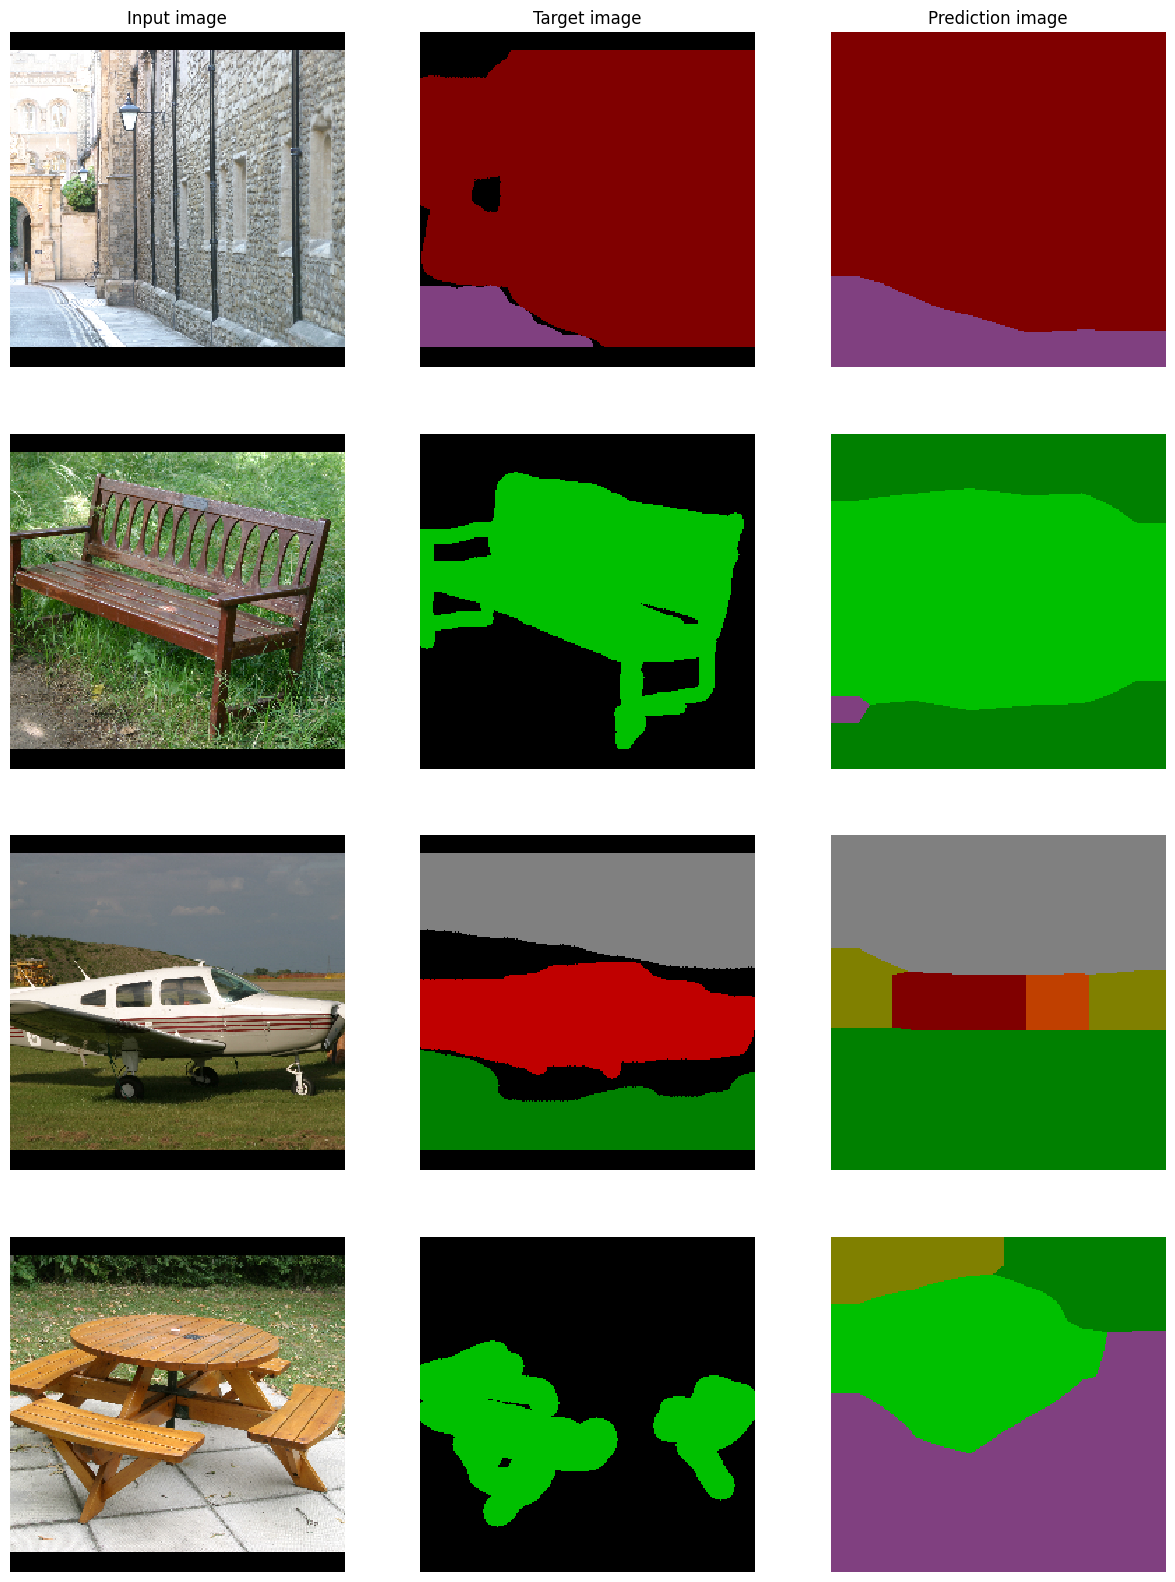

In [9]:
visualizer(model, test_data)


In [12]:
def evaluate_model(model, dataloader):
    test_scores = []
    model.eval()
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model.forward(inputs)
        _, preds = torch.max(outputs, 1)
        
        targets_mask = targets >= 0
        test_scores.append(np.mean((preds.cuda() == targets.cuda())[targets_mask].cpu().numpy()))

    return np.mean(test_scores)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=hparams["batch_size"], shuffle=False, num_workers=0)
    
evaluate_model(model,test_loader)

0.7207483779869989

In [13]:
# os.getcwd()

'/home/mywsl/Redo/Semantic_Segmentation'